In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import re
import itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace

In [3]:
# logging set-up
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
# Make deterministic
random.seed(47)
torch.manual_seed(47);

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
# path = Path('/data/s4314719/image-captioning/')  # set this to the path where the dataset should be stored
# path = Path('/image_data/')  # set this to the path where the dataset should be stored
# path = Path('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/')

path.mkdir(exist_ok=True)

NameError: name 'path' is not defined

In [7]:
img_dir = path/'Flicker8k_Dataset'
ann_file = path/'Flickr8k.token.txt'

In [8]:
URL = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/'
FILENAMES = ['Flickr8k_text.zip', 'Flickr8k_Dataset.zip']

In [9]:
# Download dataset
import requests
from zipfile import ZipFile

for fn in FILENAMES:
    if not (path/fn).exists():  # do not download if the dataset has already been downloaded
        print(f'Downloading {fn}')
        r = requests.get(URL + fn)
        (path/fn).write_bytes(r.content)
        print(f'Extracting files...')
        with ZipFile(path/fn) as zipf:
            zipf.extractall(path)

In [9]:
list(path.glob('*')) # list all files

[WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/CrowdFlowerAnnotations.txt'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/ExpertAnnotations.txt'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flicker8k_Dataset'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flickr8k.lemma.token.txt'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flickr8k.token.txt'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flickr8k_Dataset.zip'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flickr8k_text.zip'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flickr_8k.devImages.txt'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flickr_8k.testImages.txt'),
 WindowsPath('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/Flic

In [10]:
print((path/'Flickr8k.token.txt').read_text()[:696])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .


In [11]:
from torch.utils.data import Dataset, DataLoader
from src.caption_utils import preprocess_tokens
from PIL import Image

class FlickrDataset(Dataset):
    unk_token = '<UNKNOWN>'
    ns_token = '<NOTSET>'
    start_token = '<START>'
    end_token = '<END>'
        
    def __init__(self, img_dir, img_captions_enc, known_words, img_ids, trnsf=None):
        self.img_dir = Path(img_dir)
        #self.ann_file = Path(ann_file)
        self.trnsf = trnsf
        self.annotations = {}
        self.targets = {}
        self.known_words = known_words
        
        # Preprocess the image captions
        #print(ann_file)
        #img_captions_enc, self.known_words, _ = preprocess_tokens(ann_file)
        end_idx = list(self.known_words.keys()).index(self.end_token)
        # the targets are the captions shifted one place to the right.
        target_lst = [[c[i] for i in range(1, len(c)) if c[i] != self.ns_token] 
                      for c in list(zip(*img_captions_enc))[1]]
        
        # iterate through the annotation file and create (image, caption) pairs
        img_ids = Path(img_ids).read_text().split('\n')
        for i, (img_id, annotation) in enumerate(img_captions_enc):
            # TODO: we only consider the first of 5 annotations for each image. Do something with the other four.
            if img_id in self.annotations or not (img_dir/img_id).exists() or not img_id in img_ids:
                continue
            self.annotations.update({img_id: annotation})
            self.targets.update({img_id: target_lst[i]})
        self.img_ids = list(self.annotations.keys())
        
    def __len__(self): 
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        annotation = self.annotations[img_id]
        annotation_len = len(annotation)
        im = Image.open(self.img_dir/img_id)
        if self.trnsf is not None:
            im = self.trnsf(im)
        target = self.targets[img_id]
        return im, np.array(annotation), annotation_len, np.array(target)
    
    def decode_caption(self, caption):
        res = ''
        for word_idx in caption:
            res += list(self.known_words.keys())[word_idx]
            res += ' '
        return res

### Preprocessing the images

In [12]:
# Calculate mean and standard deviation over all channels for normalization
# mean = torch.cat([ex[0].view(3, -1) for ex in data], 1).mean(1)
# std = torch.cat([ex[0].view(3, -1) for ex in data], 1).std(1)
mean = np.array([0.4629, 0.4468, 0.4050])
std = np.array([0.2661, 0.2587, 0.2727])

In [14]:
from torchvision import transforms

# We resize the images and center crop them, as in the 'Show, attend and tell' paper. In the paper they
# resize the shortest side to 256 while preserving the aspect ratio, and then apply a center crop to 
# end up with an image of size 224x224. Note that for quick experimentation, we can use a smaller image 
# size (e.g. 128x128) to speed up training. 
trnsf = {
    'train': transforms.Compose([
        transforms.Resize(128),
#         transforms.Resize(256),
        transforms.CenterCrop(128),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize(128),
#         transforms.Resize(256),
        transforms.CenterCrop(128),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
}

C:\Users\leann\Documents\Master AI IS\Deep Learning\Github repository2\image-captioning\torchvision\__init__.py:26: UserWarning: You are importing torchvision within its own root folder (C:\Users\leann\Documents\Master AI IS\Deep Learning\Github repository2\image-captioning). This is not expected to work and may give errors. Please exit the torchvision project source and relaunch your python interpreter.
  warnings.warn(message.format(os.getcwd()))


### Preprocessing the captions

In [ ]:
# Calls the preprocessing of the captions which may take a while (progress is printed)
img_captions_enc, known_words, _ = preprocess_tokens(ann_file)

### Split data up into train and evaluation set

In [22]:
# We use the predefined train/eval splits of Flickr8k
ds_train = FlickrDataset(img_dir, img_captions_enc, known_words,  path/'Flickr_8k.trainImages.txt', trnsf=trnsf['train'])
ds_eval = FlickrDataset(img_dir, img_captions_enc, known_words, path/'Flickr_8k.devImages.txt', trnsf=trnsf['eval'])
len(ds_train), len(ds_eval)

10/03/2021 10:12:36 - src.caption_utils - INFO - Creating word dictionary: 0/40461
10/03/2021 10:12:41 - src.caption_utils - INFO - Creating word dictionary: 10000/40461
10/03/2021 10:12:45 - src.caption_utils - INFO - Creating word dictionary: 20000/40461
10/03/2021 10:12:49 - src.caption_utils - INFO - Creating word dictionary: 30000/40461
10/03/2021 10:12:53 - src.caption_utils - INFO - Creating word dictionary: 40000/40461
10/03/2021 10:12:54 - src.caption_utils - INFO - Replacing tokens with numerical values: 0/40461


{'<NOTSET>': 0, '<UNKNOWN>': 0, '<START>': 0, '<END>': 0, 'a': 62989, 'in': 18975, 'the': 18419, 'on': 10744, 'is': 9345, 'and': 8852, 'dog': 8136, 'with': 7765, 'man': 7266, 'of': 6713, 'two': 5639, 'white': 3940, 'black': 3832, 'boy': 3581, 'are': 3505, 'woman': 3403, 'girl': 3328, 'to': 3173, 'wearing': 3062, 'at': 2916, 'people': 2887, 'water': 2783, 'red': 2672, 'young': 2630, 'brown': 2563, 'an': 2432, 'his': 2357, 'blue': 2268, 'dogs': 2125, 'running': 2073, 'through': 2032, 'playing': 2008, 'while': 1968, 'down': 1825, 'shirt': 1806, 'standing': 1789, 'ball': 1779, 'little': 1768, 'grass': 1622, 'child': 1545, 'person': 1542, 'snow': 1492, 'jumping': 1472, 'over': 1414, 'front': 1386, 'three': 1383, 'sitting': 1368, 'holding': 1324, 'field': 1280, 'small': 1278, 'up': 1260, 'by': 1248, 'large': 1236, 'green': 1225, 'one': 1218, 'group': 1218, 'yellow': 1213, 'her': 1178, 'walking': 1165, 'children': 1156, 'men': 1121, 'into': 1074, 'air': 1058, 'beach': 1046, 'near': 1026, 'mou

KeyboardInterrupt: 

In [16]:
# show an example from the dataset
img = '1000268201_693b08cb0e.jpg'
caption = ds_train.annotations[img]
print(img)
print(caption)
print(ds_train.decode_caption(caption))

1000268201_693b08cb0e.jpg
[2, 44, 6, 4, 92, 172, 9, 121, 55, 4, 398, 14, 395, 6, 30, 1, 695, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
<START> child in a pink dress is climbing up a set of stairs in an <UNKNOWN> way  <END> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> 


### Visualizing some images

In [17]:
def imshow(im):
    imnp = im.numpy()
    imnp = imnp * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]  # undo normalization
    imnp = np.clip(imnp, 0, 1)
    imnp = imnp.transpose([1, 2, 0])
    plt.imshow(imnp)

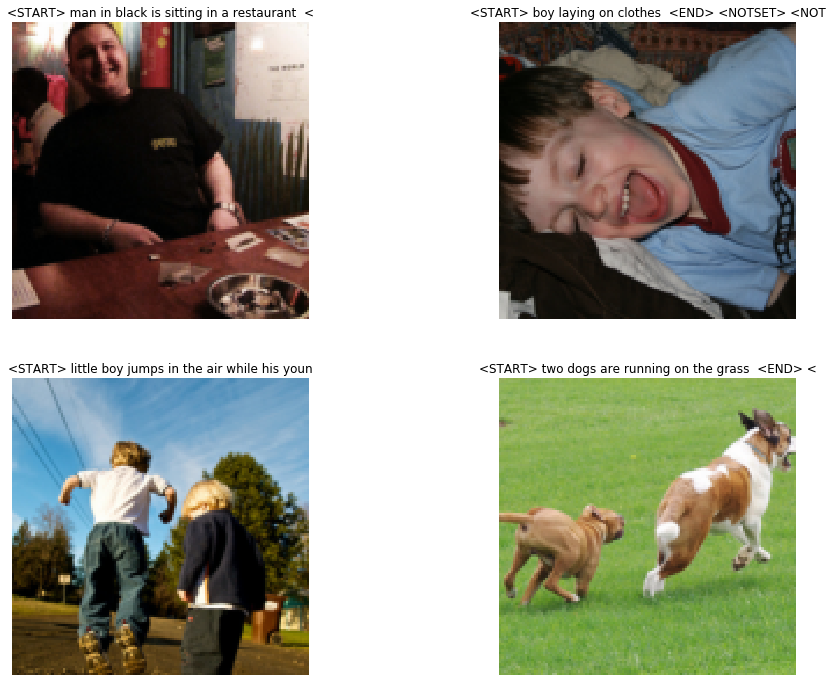

In [18]:
# Plot some examples from the training set
from matplotlib import pyplot as plt

nrows = 2
ncols = 2
plt.figure(figsize=(16, 12))
for i in range(nrows * ncols):
    idx = random.randint(0, len(ds_train)-1)
    im, caption, _, _ = ds_train[idx]
    plt.subplot(nrows, ncols, i+1)
    plt.title(ds_train.decode_caption(caption)[:50])  # TODO: modify this to show the entire caption correctly
    imshow(im)
    plt.axis('off')

### Model initialization and training

In [19]:
# dummy variables
vocab_size = 10000
num_hidden = 512
embedding_dim = 512
batch_size = 128
lr = 0.01

In [20]:
from src.models import EncoderDecoder, LSTMDecoder, get_encoder

encoder = get_encoder(num_hidden)
decoder = LSTMDecoder(num_hidden, embedding_dim, vocab_size, device)
encoder, decoder = encoder.to(device), decoder.to(device)

model = EncoderDecoder(encoder, decoder)
model.to(device);

In [21]:
model

EncoderDecoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [22]:
optimizer = optim.Adam(model.parameters())

In [23]:
# overfit on a mini dataset
ds_mini = torch.utils.data.Subset(ds_train, [0, 1])

In [24]:
from src.trainer import Trainer, TrainerConfig

config = TrainerConfig(batch_size=128, epochs=100, num_workers=0)
trainer = Trainer(config, model, optimizer, ds_mini, ds_eval)

In [87]:
trainer.train()  # overfit on a mini dataset for a quick sanity check

07/03/2021 18:16:26 - src.trainer - INFO - Epoch 0 - train_loss: 9.2075
07/03/2021 18:16:26 - src.trainer - INFO - Epoch 1 - train_loss: 8.1841
07/03/2021 18:16:26 - src.trainer - INFO - Epoch 2 - train_loss: 6.7240
07/03/2021 18:16:26 - src.trainer - INFO - Epoch 3 - train_loss: 5.0962
07/03/2021 18:16:27 - src.trainer - INFO - Epoch 4 - train_loss: 3.6292
07/03/2021 18:16:27 - src.trainer - INFO - Epoch 5 - train_loss: 3.0116
07/03/2021 18:16:27 - src.trainer - INFO - Epoch 6 - train_loss: 3.0856
07/03/2021 18:16:27 - src.trainer - INFO - Epoch 7 - train_loss: 2.9693
07/03/2021 18:16:28 - src.trainer - INFO - Epoch 8 - train_loss: 2.7310
07/03/2021 18:16:28 - src.trainer - INFO - Epoch 9 - train_loss: 2.4645
07/03/2021 18:16:28 - src.trainer - INFO - Epoch 10 - train_loss: 2.2006
07/03/2021 18:16:28 - src.trainer - INFO - Epoch 11 - train_loss: 1.9137
07/03/2021 18:16:29 - src.trainer - INFO - Epoch 12 - train_loss: 1.6456
07/03/2021 18:16:29 - src.trainer - INFO - Epoch 13 - train_l